## Imports

In [1]:
import logging
logging.basicConfig()
#logging.getLogger().setLevel(logging.INFO)
logging.getLogger("tifffile").setLevel(logging.CRITICAL)
logging.getLogger("tifffile.tifffile").setLevel(logging.CRITICAL)
logging.getLogger("tifffile.TiffPage").setLevel(logging.CRITICAL)
logging.getLogger("imageio").setLevel(logging.CRITICAL)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from gratin_exp.specht_experiment import SpechtExperiment
from palmari import TifPipeline, Acquisition
from palm_tools.post_processing.ts_post_processing import PostProcessingStepSeries
from palm_tools.post_processing.tif_post_processing import TifPostProcessingStepSeries
from palm_tools import TrackSets, TrackSet

from gratin_exp.tag_synapses import TagSynapses, TagSynapsesGraphClustering
from palm_tools.post_processing.gratin import Gratin, GratinAllLengths, GratinParameters
from palm_tools.post_processing.diffusivity import StepsAndDiffusion, ConvexHullAsymmetry
from tqdm import tqdm
from matplotlib.colors import TwoSlopeNorm
import warnings
from gratin_exp.toolbox.rois import *

#warnings.simplefilter("module")

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
DATA_FOLDER = "/home/hverdier/Gaia/hecat/hippo/PALM/cspecht/Exp10_11_12"
EXPORT_FOLDER = "/home/hverdier/Gaia/hecat/hippo/PALM/processed/cspecht"

In [3]:
exp = SpechtExperiment(data_folder=DATA_FOLDER,export_folder=EXPORT_FOLDER)

In [4]:
tp = TifPipeline.from_dict(
        {
            "name": "default_with_percentile_filtering",
            "movie_preprocessors": [
                {"WindowPercentileFilter": {"percentile": 5, "window_size": 300}}
            ],
            "tracker": {"TrackpyTracker": {"max_diffusivity": 10.0}},
        }
    )

tp.process(exp,force_reprocess=False)

In [5]:
acq = Acquisition(exp[0],exp,tp)
df = acq.locs
df.shape[0]


450217

In [6]:
df.head()

frame          x          y     ratio     sigma  total_intensity  \
0      0  11.416976  32.944731  2.823223  4.153551          15464.0   
1      0  12.149826  21.840829  2.159571  4.442684          20245.0   
2      0  14.515518  35.872985  2.513727  4.271478          20553.0   
3      0  19.200062  31.654483  1.007894  3.956501          22346.0   
4      0  20.140269  24.902079  2.186813  4.415035          21919.0   

   detection_index    t   n  synapse_ID  ...         D  est_sigma  n_points  \
0               17  0.0  48          -1  ...  1.340711   0.055643         7   
1               20  0.0  65    79454346  ...  1.728433   0.088698         9   
2               27  0.0  83    22186813  ...  0.825707   0.082246         7   
3               35  0.0  75          -1  ...  0.980871   0.171172         8   
4               37  0.0  73          -1  ...  0.521838   0.092060        12   

   duration  index  qhull_surface  qhull_volume  diameter  asymmetry  \
0     0.090      0       1.146506      0.059352  0.491932   0.010378   
1     0.120      0       1.220209      0.050285  0.565563   0.013218   
2     0.090      0       0.851091      0.042290  0.326782   0.004059   
3     0.105      0       1.442907      0.087313  0.602985   0.008128   
4     0.165      0       0.960211      0.043145  0.377447   0.000906   

   fractal_dimension  
0          -4.453852  
1          -4.737854  
2          -3.651001  
3          -4.624782  
4          -3.416243  

[5 rows x 23 columns]

In [7]:
tag_s = TagSynapses()
tif_ps = TifPostProcessingStepSeries(tif_processing=tp, processing_steps=[tag_s])
warnings.simplefilter("ignore")
tif_ps.process(exp, force=False)

TifPostProcessing...: 100%|██████████| 26/26 [01:37<00:00,  3.75s/it, 210329 Exp10 PALM live cortex FU-aSyn/movies/Eosmov_002.tif : Tag Synapses using ROIs]    


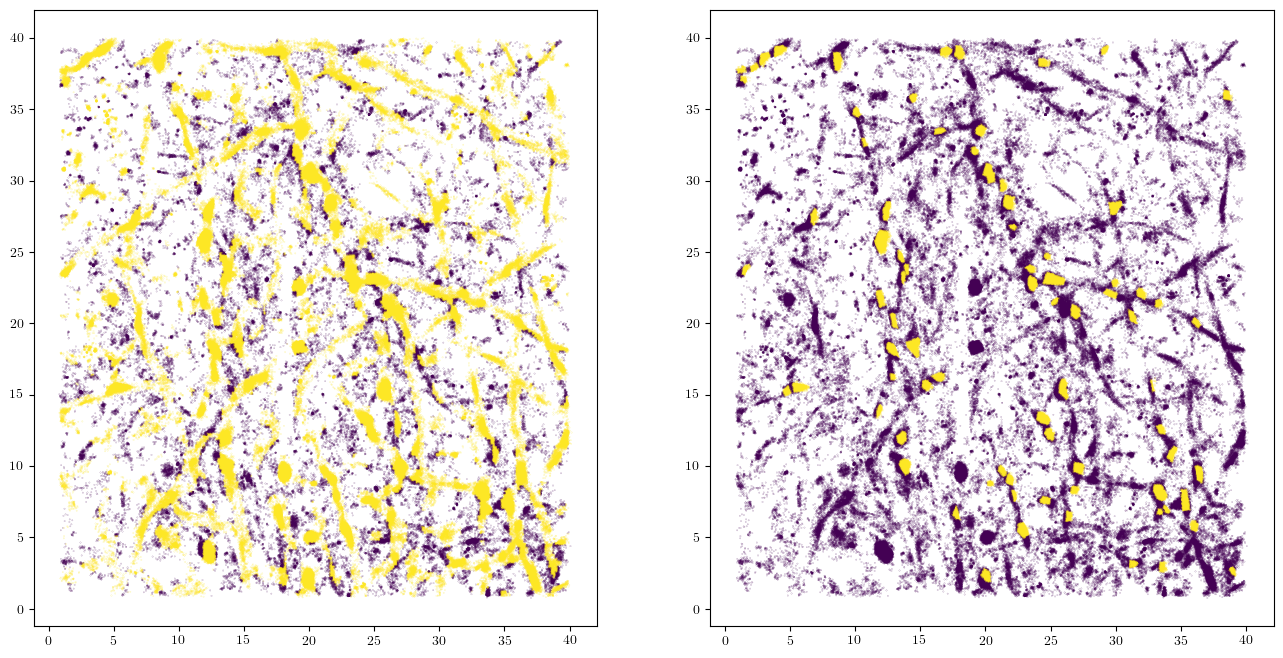

In [8]:
for f in exp.index_df["file"].tolist():
    acq = Acquisition(f, exp, tp)
    df= acq.locs
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(121)
    ax.scatter(df.x,df.y,c=df.on_axon,s=.01)
    ax = fig.add_subplot(122)
    ax.scatter(df.x,df.y,c=df.synapse_ID>= 0,s=.01)
    break

In [9]:
tss = TrackSets.from_experiment(exp,tp)

In [10]:
tss[0].locs.head()

frame          x          y     ratio     sigma  total_intensity  \
0      0  11.416976  32.944731  2.823223  4.153551          15464.0   
1      0  12.149826  21.840829  2.159571  4.442684          20245.0   
2      0  14.515518  35.872985  2.513727  4.271478          20553.0   
3      0  19.200062  31.654483  1.007894  3.956501          22346.0   
4      0  20.140269  24.902079  2.186813  4.415035          21919.0   

   detection_index    t   n  synapse_ID  ...         D  est_sigma  n_points  \
0               17  0.0  48          -1  ...  1.340711   0.055643         7   
1               20  0.0  65    79454346  ...  1.728433   0.088698         9   
2               27  0.0  83    22186813  ...  0.825707   0.082246         7   
3               35  0.0  75          -1  ...  0.980871   0.171172         8   
4               37  0.0  73          -1  ...  0.521838   0.092060        12   

   duration  index  qhull_surface  qhull_volume  diameter  asymmetry  \
0     0.090      0       1.146506      0.059352  0.491932   0.010378   
1     0.120      0       1.220209      0.050285  0.565563   0.013218   
2     0.090      0       0.851091      0.042290  0.326782   0.004059   
3     0.105      0       1.442907      0.087313  0.602985   0.008128   
4     0.165      0       0.960211      0.043145  0.377447   0.000906   

   fractal_dimension  
0          -4.453852  
1          -4.737854  
2          -3.651001  
3          -4.624782  
4          -3.416243  

[5 rows x 23 columns]

In [10]:
for i in range(len(tss)):
    ts = tss[i]
    ts.locs["on_synapse"] = ts.locs["synapse_ID"] > -1

In [12]:
#gratin_path = "/home/hverdier/Gaia/hecat/hippo/models/demo_28aout"
gratin_path = "/home/hverdier/Gaia/hecat/hippo/models/gratin_20sept"
gt = GratinAllLengths(GratinParameters(path=gratin_path))
sd = StepsAndDiffusion()
ch = ConvexHullAsymmetry()

In [13]:
ps_run = PostProcessingStepSeries([sd,gt,ch])

In [14]:
ps_run.process(tss)

Processing in PPSS : 100%|██████████| 26/26 [48:09<00:00, 111.14s/it, /home/hverdier/Gaia/hecat/hippo/PALM/processed/cspecht/default_with_percentile_filtering/210329 Exp10 PALM live cortex FU-aSyn/movies/Eosmov_002.locs : Convex hull and assymmetry]    


In [15]:
RUN_NAME = "TEST_RUN"

In [18]:
def mode(df):
    return df.value_counts(dropna=False).index[0]

In [16]:
from palm_tools.analysis.mmd_analysis import MMDInterUnitAnalysis

def only_synapses(df):
    return df.on_synapse

mmd = MMDInterUnitAnalysis(track_sets=tss,
        run_name="second",
        n_bootstraps=10,
        unit_key=["synapse_ID"], 
        cond_filter={},
        locs_cols_to_keep={"synapse_ID":mode},
        unbiased=False,
        filter_func=only_synapses,
        n_max_trajs_per_unit=300,
        n_min_trajs_per_unit=300,
        use_high_dimension=False)

In [17]:
mmd.process()
mean_D = mmd.D_true
std_D  = mmd.D_sigma

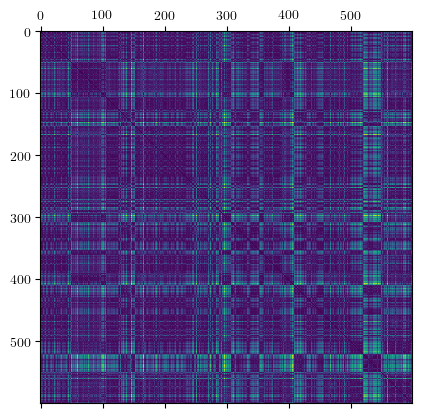

In [18]:
plt.matshow(mean_D)

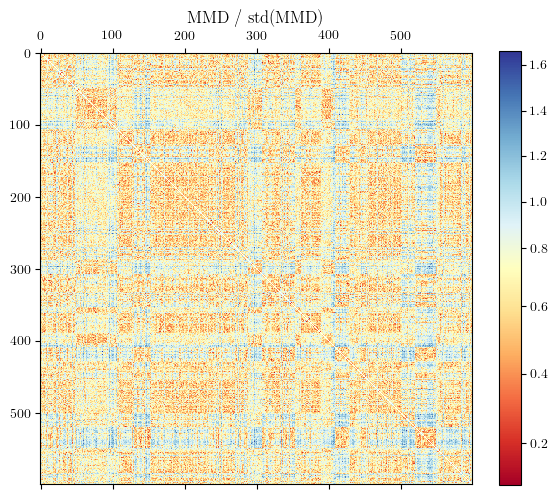

In [19]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
log_ratio = np.log10(mean_D/std_D)
cb = ax.matshow(log_ratio,norm=TwoSlopeNorm(vmin=np.nanmin(log_ratio),
    vcenter=0 if np.nanmin(log_ratio) < 0 else np.nanmedian(log_ratio),
    vmax=np.nanmax(log_ratio)),
    cmap="RdYlBu")
plt.colorbar(cb)
plt.title("MMD / std(MMD)")
plt.tight_layout()

In [20]:
from palm_tools.analysis.mds_analysis import MDSAnalysis
from sklearn.manifold import MDS

mds = MDSAnalysis(track_sets=tss,run_name="test",mmd=mmd,filter_func=None,dimension=2)

In [21]:
mds.process(force_recompute=True)

100%|██████████| 1000/1000 [00:02<00:00, 338.93it/s, loss=0.00112]


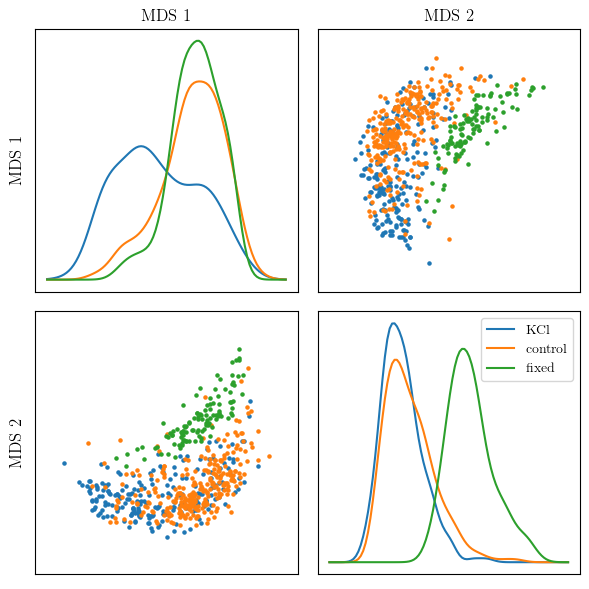

In [22]:
mds.plot_scatter(groupby="condition")
plt.legend()

In [27]:
from palm_tools.analysis.mmd_analysis import MMDInterGroupAnalysis
def axons_only(df):
    return df.on_axon

def syn_only(df):
    return df.on_synapse
    
mmd_syn = MMDInterGroupAnalysis(track_sets=tss,run_name="axons_vs_synapses",
    n_processes=8,
    group_by_keys=["condition","on_synapse"],
    cond_filter={},
    n_max_bootstraps=250,
    n_max_trajs_per_unit=500,
    n_min_trajs_per_unit=500,
    unit_key=["file","on_synapse"],
    locs_cols_to_keep={"log_D":"first","on_synapse":mode},
    null_mode="mix",
    filter_func=axons_only,
    show_progress=True,
    use_high_dimension=False,
    min_granularity=2
)

In [29]:
mmd_syn.process(force_recompute=True)

Adding units from tracksets: 100%|██████████| 26/26 [03:44<00:00,  8.65s/it, 27017 trajs from /home/hverdier/Gaia/hecat/hippo/PALM/processed/cspecht/default_with_percentile_filtering/210329 Exp10 PALM live cortex FU-aSyn/movies/Eosmov_003bis.locs] 
(250 bootstraps) : {'condition': 'fixed', 'on_synapse': False} VS {'condition': 'fixed', 'on_synapse': True}: 100%|██████████| 9/9 [26:41<00:00, 177.89s/it]   


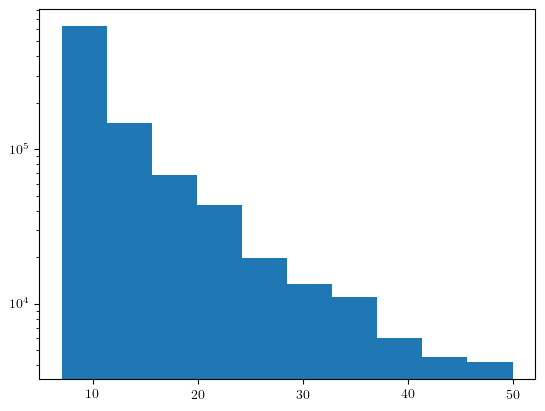

In [24]:
plt.hist(mmd_syn.latent_df.groupby(["unit","n"])[["L"]].max(),range=(7,50))
plt.yscale("log")

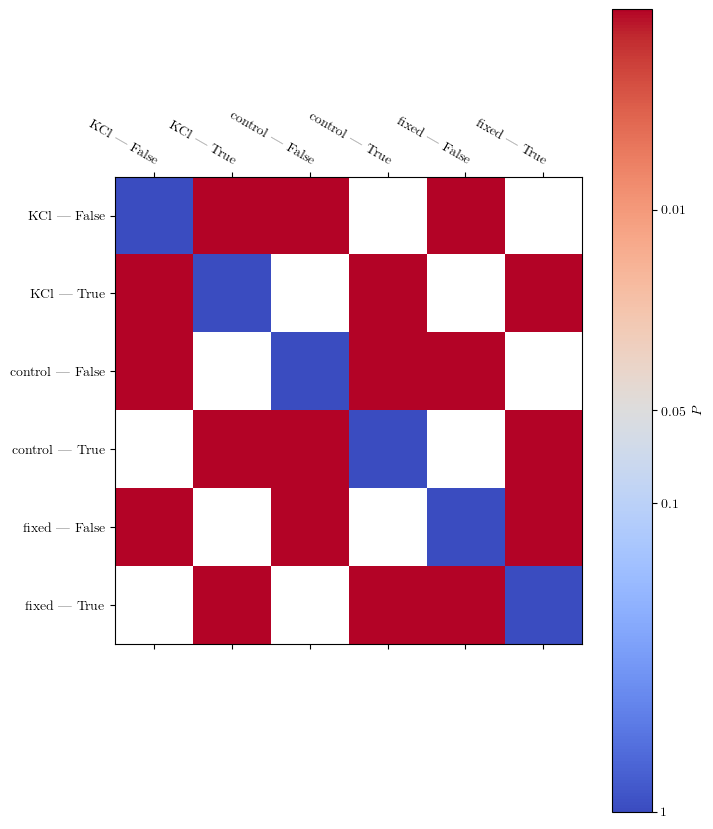

In [25]:
mmd_syn.plot_mosaic()

In [ ]:
mmd_syn.plot_latent_spaces(groups={"on_synapse":[True,False]},show_scatter=False)

In [ ]:
mmd_syn.plot_latent_spaces(groups={"on_synapse":[True,False]},show_scatter=True)

In [34]:
mmd_syn.latent_df["qhull_ratio"] = mmd_syn.latent_df["qhull_surface"]**2 / mmd_syn.latent_df["qhull_volume"]

In [ ]:
# Sauvegarder les histogrammes avec variables classiques
# Ajouter plus de variables classiques
mmd_syn.plot_discriminant_trajs(
    {"condition":"control","on_synapse":True},
    {"condition":"KCl","on_synapse":True},
    n_bootstraps = 50,
    max_n_trajs = 3000,
    pair_critical_by="FOV",
    group_labels={"on_synapse":{True:"on synapse",False:"outside synapse"}},
    histogram_cols={"log_D":"$\\log_{10}(D)$","alpha":"$\\alpha$","asymmetry":"Asymmetry","fractal_dimension":"Fractal dim.","qhull_ratio":"Perimeter / area$^2$"},
    histogram_cols_to_log=["asymmetry","qhull_ratio"],
    fig_paths={
        "histograms":"/home/hverdier/Gaia/hecat/hippo/c_specht_paper/figures/",
        "repartition":"/home/hverdier/Gaia/hecat/hippo/c_specht_paper/figures/repartition_trajectoires.pdf",
        "comparison" :"/home/hverdier/Gaia/hecat/hippo/c_specht_paper/figures/comparison_inside_synapses.pdf",
    },
    show_critical_region=True)

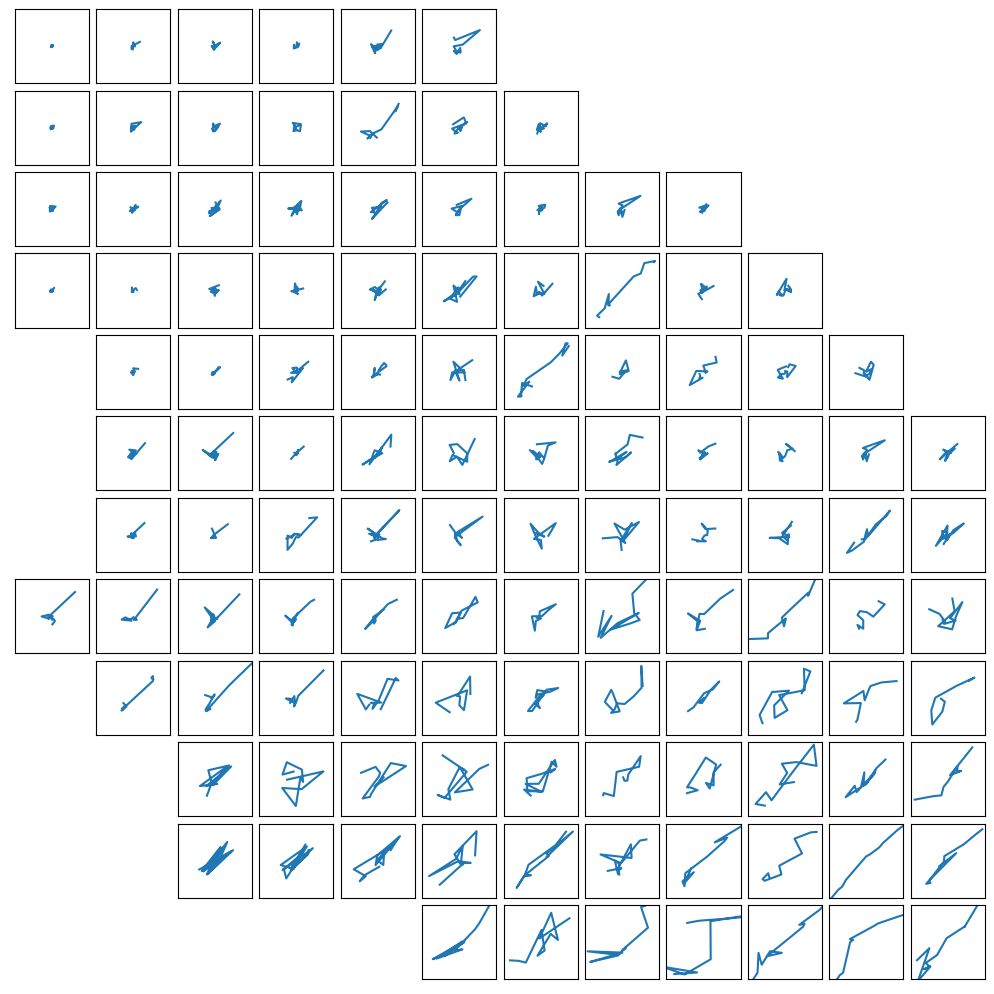

In [24]:
mmd_syn.plot_latent_map(min_length=10,max_length=14,side = 1.5, fig_path="/home/hverdier/Gaia/hecat/hippo/c_specht_paper/figures/latent_space_map.pdf")

In [33]:
mmd_syn.plot_all_comparisons(export_folder="/home/hverdier/Gaia/hecat/hippo/c_specht_paper/figures/comparisons")

fixed_False_fixed_True: 100%|██████████| 9/9 [38:04<00:00, 253.80s/it]    
